In [2]:
import os
import argparse
import networkx as nx
import math        
import numpy as np
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time

def get_rval(x):
    tmp = randint(0,99)
    if tmp%2:
        return randint(0,x-1)
    else:
        return randint(x+1,9)

def get_rval2(x):
    x1 = get_rval(x)
    x2 = get_rval(x)
    while abs(x1-x2)==1:
        x1 = get_rval(x)
        x2 = get_rval(x)
    return x1, x2

def get_random_occ_grid():
    row1 = randint(1,8)
    row2 = randint(1,8)
    while(row2 == row1 and row2 == row1 - 1 and row2 == row1 + 1):
        row2 = randint(1,8)
    col = randint(2,7)

    rc1, rc2 = get_rval2(col)
    cr1_1, cr1_2 = get_rval2(row1)
    cr2_1, cr2_2 = get_rval2(row2)

    occ_grid = np.ones((10,10))
    
    for i in range(10):
        if not (i==cr1_1 or i==cr1_2):
            occ_grid[row1,i] = 0

        if not (i==rc1 or i==rc2):
            occ_grid[i,col] = 0
            
        if not (i==cr2_1 or i==cr2_2):
            occ_grid[row2,i] = 0
            
            
    return occ_grid, row1, col



# Generating "DOF" definition of Landmark

In [4]:
total_data = 0
for num_data in range(total_data):
    occ_g, row1, col = get_random_occ_grid()
    data = occ_g.reshape(100)
    #fig1 = plt.figure(figsize=(10,6), dpi=80)
    #ax1 = fig1.add_subplot(111, aspect = 'equal')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    num_landmark = 1000
    num_neighbor = 200
    radius_landmark = 0.7
    #landmark = np.zeros((num_landmark, 2))
    #graph = nx.Graph()
    cnt = 0
    for i in range(num_landmark):
        x = np.random.uniform(0, 10)
        y = np.random.uniform(0, 10)
        if occ_g[int(x)][int(y)] == 0:
            continue

        ratio = 0.0
        minus = 0.0
        for j in range(num_neighbor):
            r = np.random.uniform(0, radius_landmark)
            theta = np.random.uniform(0, 2*np.pi)
            x_ = x + r * np.cos(theta)
            y_ = y + r * np.sin(theta)
            if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
                minus += 1
                continue
            if occ_g[int(x_)][int(y_)] == 1:
                ratio += 1
        ratio = ratio / (num_neighbor - minus)
        #graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
        if ratio <= 0.9:
            #print(ratio)
            data = np.append(data,x)
            data = np.append(data,y)
            #plt.scatter(x/10, y/10, color = 'blue', s = 10)
    '''
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))
    plt.show()
    '''
    print(num_data, data.shape)
    np.save('/home/zhizuo/lego/dataset/landmark_{}'.format(str(num_data)),data)

In [5]:
import torch.nn as nn
import torch.nn.functional as F


# =======================
# CVAE (MLP version)
# =======================
class CVAE_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
        self.fc1 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x, c):
        inputs = torch.cat((x, c), 1)
        outputs = self.encoder(inputs)
        z_mu = self.fc1(outputs)
        z_logvar = self.fc2(outputs)
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        
        inputs_1 = torch.cat((z,c), 1)
        
        outputs_1 = self.decoder(inputs_1)
        return z_mu, z_logvar, outputs_1

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# =======================
# CVAE (CNN version)
# =======================
class CVAE_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        def c_block(in_filters, out_filters, kernel_size = 3, stride = 1, padding = 1, bn=False):
            if bn:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.BatchNorm2d(out_filters),
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            else:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            return block
        
        #self.deconv_en = nn.ConvTranspose2d(2,1,10, stride = 1, padding=0)
        #self.decon_de = nn.ConvTranspose2d(2,1,10, stride = 1, padding = 0)
        
        # ====================
        # Encoder part
        # ====================
        self.deconv_en = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.encoder = nn.Sequential(
            *c_block(7,   32, 3, 2, 1),
            *c_block(32,  64, 3, 1, 0),
            *c_block(64,  128, 3, 1, 0),
        )
        
        self.mu_mlp = nn.Linear(128, 2)
        self.logvar_mlp = nn.Linear(128, 2)
        
        # ====================
        # Decoder part
        # ====================
        self.deconv_de = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.decoder = nn.Sequential(
            *c_block(7,   32, 3, 2, 1),
            *c_block(32,  64, 3, 1, 0),
            *c_block(64,  128, 3, 1, 0),
        )
        
        self.predict_mlp = nn.Linear(128, 2)
        
        
    def forward(self, x, c):
        # Encoder
        x = x.view(x.shape[0], 2, 1, -1)
        cat = c[:, 0:4]
        cat = cat.view(cat.shape[0], 4, 1, -1)
        x_en = torch.cat((x, cat), 1)
        c_en = c[:, 4:].view(c.shape[0], 1, 10, -1)
        deconv_x = self.deconv_en(x_en)
        input_en = torch.cat((deconv_x, c_en), 1)
        output_en = self.encoder(input_en)
        output_en = output_en.view(output_en.shape[0], 1, -1)
        z_mu = self.mu_mlp(output_en)
        z_logvar = self.logvar_mlp(output_en)

        
        # Latent space
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        z = z.view(z.shape[0], 2, 1, -1)
        # Decoder 
        z = torch.cat((z, cat), 1)
        z_deconv = self.deconv_de(z)
        input_decoder = torch.cat((z_deconv,c_en), 1)
        output_decoder = self.decoder(input_decoder)
        output_decoder = output_decoder.view(output_decoder.shape[0], 1, -1)
        predict = self.predict_mlp(output_decoder)
        predict = predict.view(predict.shape[0],-1)
        return z_mu, z_logvar, predict

    
def KL_loss(z_mu, z_logvar):
    return 2 * torch.sum(torch.exp(z_logvar) + 
                        z_mu**2 - 1. - z_logvar, dim=1).mean()
def Recon_loss(labels, predictions):
    loss = nn.MSELoss()
    return loss(labels, predictions)



In [9]:
import argparse
from torch import optim
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()
parser.add_argument("--max_epochs", type=int, default=4000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--eps", type=float, default=1e-8, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
#parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
#parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
#parser.add_argument("--channels", type=int, default=1, help="number of image channels")
#parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

landmark_data = []
total_data = 50
for i in range(total_data):
    data = np.load('/home/zhizuo/lego/dataset/landmark_{}.npy'.format(str(i)))
    length = data.shape[0]
    for j in range(int((length - 100)/2)) :
        tmp = np.concatenate((data[0:100], data[(100+j*2):(100+j*2+2)]))
        landmark_data.append(tmp)
        
landmark_data = np.array(landmark_data)
print(landmark_data.shape)
    
class LandmarkSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)
    



Namespace(b1=0.9, b2=0.999, batch_size=128, eps=1e-08, lr=0.0001, max_epochs=4000, n_cpu=8)
(8522, 102)


# Train for Lego Dataset

In [27]:
from torch.utils.data import Dataset, DataLoader
import networkx as nx
from process_it import process_it

# ==============================
# Lego shortest path dataset
# ==============================

class LegoSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)

    
G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset"

directory = data_dir
print(directory)
data = np.array(process_it(G, directory))
print("shape of array: ", data.shape)
numEntries = data.shape[0]
dim = 2
dataElements = dim * 3 + 10 * 10
z_dim = 2
X_dim = dim
y_dim = dim
ratioTestTrain = 0.8
numTrain = int(numEntries * ratioTestTrain)
X_train = data[0:numTrain, 0:dim]
c_train = data[0:numTrain, dim:dataElements]

X_test = data[numTrain:numEntries, 0:dim]
c_test = data[numTrain:numEntries, dim:dataElements]

path = "/Users/zhangzhizuo/Desktop/UCSD/Su Lab/Code Lego/"
train_data = LegoSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
test_data = LegoSet(x = X_test, c = c_test, train = False)
test_loader = DataLoader(test_data, batch_size = opt.batch_size, shuffle = False)

net = CVAE_CNN()
resume = None
#resume = "./Model/CVAE_CNN_2020_3_19_21.pkl"
if resume == None:
    net = CVAE_CNN()
else:
    net.load_state_dict(torch.load(resume))
    
if torch.cuda.is_available():
    net.cuda()
net.train()
optimizer = optimizer = optim.Adam(net.parameters(), lr=opt.lr, 
                      betas=(opt.b1, opt.b2), eps=1e-08, weight_decay=0)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                            milestones = [50, 200, 500, 1000, 2000], gamma = 0.5)
epoch_loss = torch.zeros(opt.max_epochs)
epoch_recon_loss = torch.zeros(opt.max_epochs)
epoch_kl_loss = torch.zeros(opt.max_epochs)
for epoch in range(opt.max_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0
    for x, c in train_loader:
        i += 1
        batch_elements = [randint(0, numTrain - 1)
                         for n in range(0, 256)]
        
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-3
        #if epoch >= 100:
        #    beta = 10 ** -4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss[epoch] += loss
        epoch_kl_loss[epoch] += kl_loss
        epoch_recon_loss[epoch] += recon_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    epoch_loss[epoch] = epoch_loss[epoch] / i
    epoch_kl_loss[epoch] = epoch_kl_loss[epoch] / i
    epoch_recon_loss[epoch] = epoch_recon_loss[epoch] / i
    print("Average loss of epoch {} : Loss {:.8f} Recon {:.8f} KL {:.8f}".
          format(epoch + 1, epoch_loss[epoch], epoch_recon_loss[epoch], epoch_kl_loss[epoch]))
    if (epoch + 1) % 2000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(), 
                  '/home/zhizuo/lego/models/CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of {}".format(localtime))
net.eval()
epoch_loss = epoch_loss.data.numpy()
epoch_recon_loss = epoch_recon_loss.data.numpy()
epoch_kl_loss = epoch_kl_loss.data.numpy()


dataset
shape of array:  (21490, 106)
Starting the 1 epoch
Average loss of epoch 1 : Loss 0.07705709 Recon 0.07705418 KL 0.00290631
Starting the 2 epoch
Average loss of epoch 2 : Loss 0.04933393 Recon 0.04933249 KL 0.00141520
Starting the 3 epoch
Average loss of epoch 3 : Loss 0.04702605 Recon 0.04702340 KL 0.00264114
Starting the 4 epoch
Average loss of epoch 4 : Loss 0.04511630 Recon 0.04511004 KL 0.00627487
Starting the 5 epoch
Average loss of epoch 5 : Loss 0.04380847 Recon 0.04379591 KL 0.01255923
Starting the 6 epoch
Average loss of epoch 6 : Loss 0.04344178 Recon 0.04341635 KL 0.02544610
Starting the 7 epoch
Average loss of epoch 7 : Loss 0.04254358 Recon 0.04247307 KL 0.07050591
Starting the 8 epoch
Average loss of epoch 8 : Loss 0.04100816 Recon 0.04077404 KL 0.23413645
Starting the 9 epoch
Average loss of epoch 9 : Loss 0.03992999 Recon 0.03944099 KL 0.48899204
Starting the 10 epoch
Average loss of epoch 10 : Loss 0.03775861 Recon 0.03683187 KL 0.92672640
Starting the 11 epoc

Average loss of epoch 86 : Loss 0.01930995 Recon 0.01625682 KL 3.05313158
Starting the 87 epoch
Average loss of epoch 87 : Loss 0.01925463 Recon 0.01619586 KL 3.05876374
Starting the 88 epoch
Average loss of epoch 88 : Loss 0.01929606 Recon 0.01623724 KL 3.05882168
Starting the 89 epoch
Average loss of epoch 89 : Loss 0.01917242 Recon 0.01610116 KL 3.07125092
Starting the 90 epoch
Average loss of epoch 90 : Loss 0.01897410 Recon 0.01592073 KL 3.05336952
Starting the 91 epoch
Average loss of epoch 91 : Loss 0.01908477 Recon 0.01603863 KL 3.04614139
Starting the 92 epoch
Average loss of epoch 92 : Loss 0.01900637 Recon 0.01596651 KL 3.03986025
Starting the 93 epoch
Average loss of epoch 93 : Loss 0.01891762 Recon 0.01588717 KL 3.03044558
Starting the 94 epoch
Average loss of epoch 94 : Loss 0.01884070 Recon 0.01581475 KL 3.02595329
Starting the 95 epoch
Average loss of epoch 95 : Loss 0.01873925 Recon 0.01568368 KL 3.05556703
Starting the 96 epoch
Average loss of epoch 96 : Loss 0.018796

Average loss of epoch 170 : Loss 0.01651199 Recon 0.01348843 KL 3.02356410
Starting the 171 epoch
Average loss of epoch 171 : Loss 0.01644351 Recon 0.01341563 KL 3.02787542
Starting the 172 epoch
Average loss of epoch 172 : Loss 0.01637423 Recon 0.01335789 KL 3.01632953
Starting the 173 epoch
Average loss of epoch 173 : Loss 0.01645097 Recon 0.01344254 KL 3.00842881
Starting the 174 epoch
Average loss of epoch 174 : Loss 0.01635690 Recon 0.01333267 KL 3.02423120
Starting the 175 epoch
Average loss of epoch 175 : Loss 0.01645025 Recon 0.01343138 KL 3.01886463
Starting the 176 epoch
Average loss of epoch 176 : Loss 0.01630024 Recon 0.01328084 KL 3.01940966
Starting the 177 epoch
Average loss of epoch 177 : Loss 0.01627345 Recon 0.01325132 KL 3.02213264
Starting the 178 epoch
Average loss of epoch 178 : Loss 0.01625600 Recon 0.01324397 KL 3.01202226
Starting the 179 epoch
Average loss of epoch 179 : Loss 0.01634186 Recon 0.01334029 KL 3.00155830
Starting the 180 epoch
Average loss of epoc

Average loss of epoch 254 : Loss 0.01495023 Recon 0.01195889 KL 2.99134326
Starting the 255 epoch
Average loss of epoch 255 : Loss 0.01499698 Recon 0.01200859 KL 2.98838854
Starting the 256 epoch
Average loss of epoch 256 : Loss 0.01499864 Recon 0.01200920 KL 2.98944163
Starting the 257 epoch
Average loss of epoch 257 : Loss 0.01508345 Recon 0.01208386 KL 2.99958992
Starting the 258 epoch
Average loss of epoch 258 : Loss 0.01499827 Recon 0.01201531 KL 2.98296309
Starting the 259 epoch
Average loss of epoch 259 : Loss 0.01490335 Recon 0.01192317 KL 2.98017573
Starting the 260 epoch
Average loss of epoch 260 : Loss 0.01490075 Recon 0.01192475 KL 2.97600579
Starting the 261 epoch
Average loss of epoch 261 : Loss 0.01487280 Recon 0.01188439 KL 2.98840475
Starting the 262 epoch
Average loss of epoch 262 : Loss 0.01489569 Recon 0.01190894 KL 2.98675442
Starting the 263 epoch
Average loss of epoch 263 : Loss 0.01492082 Recon 0.01193401 KL 2.98681116
Starting the 264 epoch
Average loss of epoc

Average loss of epoch 338 : Loss 0.01405669 Recon 0.01107486 KL 2.98183537
Starting the 339 epoch
Average loss of epoch 339 : Loss 0.01409169 Recon 0.01109841 KL 2.99328542
Starting the 340 epoch
Average loss of epoch 340 : Loss 0.01412682 Recon 0.01114159 KL 2.98522472
Starting the 341 epoch
Average loss of epoch 341 : Loss 0.01422391 Recon 0.01123751 KL 2.98640442
Starting the 342 epoch
Average loss of epoch 342 : Loss 0.01406567 Recon 0.01107476 KL 2.99091220
Starting the 343 epoch
Average loss of epoch 343 : Loss 0.01403082 Recon 0.01104468 KL 2.98614311
Starting the 344 epoch
Average loss of epoch 344 : Loss 0.01413021 Recon 0.01113366 KL 2.99654293
Starting the 345 epoch
Average loss of epoch 345 : Loss 0.01405449 Recon 0.01107289 KL 2.98159981
Starting the 346 epoch
Average loss of epoch 346 : Loss 0.01400162 Recon 0.01102747 KL 2.97414684
Starting the 347 epoch
Average loss of epoch 347 : Loss 0.01408793 Recon 0.01111541 KL 2.97252750
Starting the 348 epoch
Average loss of epoc

Average loss of epoch 422 : Loss 0.01359631 Recon 0.01063838 KL 2.95793390
Starting the 423 epoch
Average loss of epoch 423 : Loss 0.01358055 Recon 0.01062979 KL 2.95076132
Starting the 424 epoch
Average loss of epoch 424 : Loss 0.01345994 Recon 0.01051376 KL 2.94618416
Starting the 425 epoch
Average loss of epoch 425 : Loss 0.01349181 Recon 0.01053646 KL 2.95535851
Starting the 426 epoch
Average loss of epoch 426 : Loss 0.01350495 Recon 0.01055079 KL 2.95415306
Starting the 427 epoch
Average loss of epoch 427 : Loss 0.01348884 Recon 0.01053995 KL 2.94889855
Starting the 428 epoch
Average loss of epoch 428 : Loss 0.01351915 Recon 0.01057377 KL 2.94537616
Starting the 429 epoch
Average loss of epoch 429 : Loss 0.01346167 Recon 0.01050267 KL 2.95899963
Starting the 430 epoch
Average loss of epoch 430 : Loss 0.01348854 Recon 0.01053547 KL 2.95307183
Starting the 431 epoch
Average loss of epoch 431 : Loss 0.01354654 Recon 0.01059337 KL 2.95316386
Starting the 432 epoch
Average loss of epoc

Average loss of epoch 506 : Loss 0.01297949 Recon 0.01002750 KL 2.95199418
Starting the 507 epoch
Average loss of epoch 507 : Loss 0.01298796 Recon 0.01004762 KL 2.94034219
Starting the 508 epoch
Average loss of epoch 508 : Loss 0.01296965 Recon 0.01004652 KL 2.92313504
Starting the 509 epoch
Average loss of epoch 509 : Loss 0.01298874 Recon 0.01006032 KL 2.92842293
Starting the 510 epoch
Average loss of epoch 510 : Loss 0.01300943 Recon 0.01006955 KL 2.93987966
Starting the 511 epoch
Average loss of epoch 511 : Loss 0.01298074 Recon 0.01003009 KL 2.95064902
Starting the 512 epoch
Average loss of epoch 512 : Loss 0.01306391 Recon 0.01014564 KL 2.91826844
Starting the 513 epoch
Average loss of epoch 513 : Loss 0.01297713 Recon 0.01004036 KL 2.93677139
Starting the 514 epoch
Average loss of epoch 514 : Loss 0.01293767 Recon 0.01000124 KL 2.93642640
Starting the 515 epoch
Average loss of epoch 515 : Loss 0.01303729 Recon 0.01008970 KL 2.94759989
Starting the 516 epoch
Average loss of epoc

Average loss of epoch 590 : Loss 0.01273743 Recon 0.00982967 KL 2.90775919
Starting the 591 epoch
Average loss of epoch 591 : Loss 0.01265139 Recon 0.00972229 KL 2.92909575
Starting the 592 epoch
Average loss of epoch 592 : Loss 0.01266313 Recon 0.00975270 KL 2.91042900
Starting the 593 epoch
Average loss of epoch 593 : Loss 0.01262566 Recon 0.00969345 KL 2.93221974
Starting the 594 epoch
Average loss of epoch 594 : Loss 0.01260385 Recon 0.00968033 KL 2.92352486
Starting the 595 epoch
Average loss of epoch 595 : Loss 0.01260309 Recon 0.00968283 KL 2.92025137
Starting the 596 epoch
Average loss of epoch 596 : Loss 0.01263359 Recon 0.00972052 KL 2.91307068
Starting the 597 epoch
Average loss of epoch 597 : Loss 0.01259807 Recon 0.00969319 KL 2.90487480
Starting the 598 epoch
Average loss of epoch 598 : Loss 0.01262201 Recon 0.00969915 KL 2.92285943
Starting the 599 epoch
Average loss of epoch 599 : Loss 0.01262794 Recon 0.00970806 KL 2.91987729
Starting the 600 epoch
Average loss of epoc

Average loss of epoch 674 : Loss 0.01242666 Recon 0.00953844 KL 2.88821459
Starting the 675 epoch
Average loss of epoch 675 : Loss 0.01232004 Recon 0.00941046 KL 2.90957499
Starting the 676 epoch
Average loss of epoch 676 : Loss 0.01233072 Recon 0.00940124 KL 2.92948198
Starting the 677 epoch
Average loss of epoch 677 : Loss 0.01232021 Recon 0.00940681 KL 2.91339588
Starting the 678 epoch
Average loss of epoch 678 : Loss 0.01227998 Recon 0.00939018 KL 2.88980174
Starting the 679 epoch
Average loss of epoch 679 : Loss 0.01228844 Recon 0.00939890 KL 2.88954067
Starting the 680 epoch
Average loss of epoch 680 : Loss 0.01230435 Recon 0.00941351 KL 2.89084125
Starting the 681 epoch
Average loss of epoch 681 : Loss 0.01235031 Recon 0.00944192 KL 2.90839338
Starting the 682 epoch
Average loss of epoch 682 : Loss 0.01223669 Recon 0.00933223 KL 2.90445805
Starting the 683 epoch
Average loss of epoch 683 : Loss 0.01231895 Recon 0.00942247 KL 2.89647317
Starting the 684 epoch
Average loss of epoc

Average loss of epoch 758 : Loss 0.01215783 Recon 0.00927026 KL 2.88757253
Starting the 759 epoch
Average loss of epoch 759 : Loss 0.01206785 Recon 0.00916746 KL 2.90038514
Starting the 760 epoch
Average loss of epoch 760 : Loss 0.01213364 Recon 0.00923782 KL 2.89582205
Starting the 761 epoch
Average loss of epoch 761 : Loss 0.01203727 Recon 0.00914270 KL 2.89457202
Starting the 762 epoch
Average loss of epoch 762 : Loss 0.01201384 Recon 0.00912307 KL 2.89076781
Starting the 763 epoch
Average loss of epoch 763 : Loss 0.01208721 Recon 0.00921594 KL 2.87127638
Starting the 764 epoch
Average loss of epoch 764 : Loss 0.01202980 Recon 0.00912238 KL 2.90741253
Starting the 765 epoch
Average loss of epoch 765 : Loss 0.01204374 Recon 0.00915769 KL 2.88604856
Starting the 766 epoch
Average loss of epoch 766 : Loss 0.01202501 Recon 0.00913152 KL 2.89349627
Starting the 767 epoch
Average loss of epoch 767 : Loss 0.01203363 Recon 0.00913046 KL 2.90317082
Starting the 768 epoch
Average loss of epoc

Average loss of epoch 842 : Loss 0.01178537 Recon 0.00890278 KL 2.88258767
Starting the 843 epoch
Average loss of epoch 843 : Loss 0.01182017 Recon 0.00894612 KL 2.87405515
Starting the 844 epoch
Average loss of epoch 844 : Loss 0.01186026 Recon 0.00896883 KL 2.89143157
Starting the 845 epoch
Average loss of epoch 845 : Loss 0.01192260 Recon 0.00903285 KL 2.88974833
Starting the 846 epoch
Average loss of epoch 846 : Loss 0.01175989 Recon 0.00887221 KL 2.88766789
Starting the 847 epoch
Average loss of epoch 847 : Loss 0.01187513 Recon 0.00901301 KL 2.86211801
Starting the 848 epoch
Average loss of epoch 848 : Loss 0.01182600 Recon 0.00894528 KL 2.88073063
Starting the 849 epoch
Average loss of epoch 849 : Loss 0.01171626 Recon 0.00883573 KL 2.88053012
Starting the 850 epoch
Average loss of epoch 850 : Loss 0.01183876 Recon 0.00898444 KL 2.85431600
Starting the 851 epoch
Average loss of epoch 851 : Loss 0.01182215 Recon 0.00893900 KL 2.88315630
Starting the 852 epoch
Average loss of epoc

Average loss of epoch 926 : Loss 0.01155425 Recon 0.00867425 KL 2.87999845
Starting the 927 epoch
Average loss of epoch 927 : Loss 0.01162546 Recon 0.00875653 KL 2.86892653
Starting the 928 epoch
Average loss of epoch 928 : Loss 0.01158589 Recon 0.00874404 KL 2.84185171
Starting the 929 epoch
Average loss of epoch 929 : Loss 0.01163137 Recon 0.00876563 KL 2.86574054
Starting the 930 epoch
Average loss of epoch 930 : Loss 0.01153803 Recon 0.00868701 KL 2.85102224
Starting the 931 epoch
Average loss of epoch 931 : Loss 0.01168961 Recon 0.00883555 KL 2.85406327
Starting the 932 epoch
Average loss of epoch 932 : Loss 0.01164297 Recon 0.00876622 KL 2.87674928
Starting the 933 epoch
Average loss of epoch 933 : Loss 0.01161723 Recon 0.00874470 KL 2.87253118
Starting the 934 epoch
Average loss of epoch 934 : Loss 0.01161905 Recon 0.00874665 KL 2.87240934
Starting the 935 epoch
Average loss of epoch 935 : Loss 0.01163463 Recon 0.00877005 KL 2.86457872
Starting the 936 epoch
Average loss of epoc

Average loss of epoch 1010 : Loss 0.01144914 Recon 0.00857895 KL 2.87018895
Starting the 1011 epoch
Average loss of epoch 1011 : Loss 0.01144633 Recon 0.00858254 KL 2.86378360
Starting the 1012 epoch
Average loss of epoch 1012 : Loss 0.01139814 Recon 0.00854857 KL 2.84957147
Starting the 1013 epoch
Average loss of epoch 1013 : Loss 0.01146060 Recon 0.00860173 KL 2.85887623
Starting the 1014 epoch
Average loss of epoch 1014 : Loss 0.01149383 Recon 0.00862156 KL 2.87226796
Starting the 1015 epoch
Average loss of epoch 1015 : Loss 0.01145038 Recon 0.00858378 KL 2.86660600
Starting the 1016 epoch
Average loss of epoch 1016 : Loss 0.01141164 Recon 0.00855391 KL 2.85772681
Starting the 1017 epoch
Average loss of epoch 1017 : Loss 0.01133898 Recon 0.00848784 KL 2.85113621
Starting the 1018 epoch
Average loss of epoch 1018 : Loss 0.01145997 Recon 0.00861462 KL 2.84534717
Starting the 1019 epoch
Average loss of epoch 1019 : Loss 0.01137514 Recon 0.00851863 KL 2.85651994
Starting the 1020 epoch


Average loss of epoch 1092 : Loss 0.01127572 Recon 0.00839702 KL 2.87870193
Starting the 1093 epoch
Average loss of epoch 1093 : Loss 0.01131106 Recon 0.00844746 KL 2.86360621
Starting the 1094 epoch
Average loss of epoch 1094 : Loss 0.01128170 Recon 0.00840900 KL 2.87270021
Starting the 1095 epoch
Average loss of epoch 1095 : Loss 0.01136027 Recon 0.00847694 KL 2.88332963
Starting the 1096 epoch
Average loss of epoch 1096 : Loss 0.01127445 Recon 0.00839946 KL 2.87498617
Starting the 1097 epoch
Average loss of epoch 1097 : Loss 0.01125576 Recon 0.00838706 KL 2.86869502
Starting the 1098 epoch
Average loss of epoch 1098 : Loss 0.01132510 Recon 0.00845164 KL 2.87346387
Starting the 1099 epoch
Average loss of epoch 1099 : Loss 0.01121910 Recon 0.00835385 KL 2.86525035
Starting the 1100 epoch
Average loss of epoch 1100 : Loss 0.01133606 Recon 0.00846437 KL 2.87168694
Starting the 1101 epoch
Average loss of epoch 1101 : Loss 0.01126277 Recon 0.00840508 KL 2.85768676
Starting the 1102 epoch


Average loss of epoch 1174 : Loss 0.01119707 Recon 0.00834295 KL 2.85411644
Starting the 1175 epoch
Average loss of epoch 1175 : Loss 0.01116580 Recon 0.00829546 KL 2.87033510
Starting the 1176 epoch
Average loss of epoch 1176 : Loss 0.01113345 Recon 0.00827531 KL 2.85813475
Starting the 1177 epoch
Average loss of epoch 1177 : Loss 0.01119190 Recon 0.00833199 KL 2.85991049
Starting the 1178 epoch
Average loss of epoch 1178 : Loss 0.01112571 Recon 0.00826900 KL 2.85671377
Starting the 1179 epoch
Average loss of epoch 1179 : Loss 0.01118230 Recon 0.00831666 KL 2.86564279
Starting the 1180 epoch
Average loss of epoch 1180 : Loss 0.01109349 Recon 0.00824192 KL 2.85157323
Starting the 1181 epoch
Average loss of epoch 1181 : Loss 0.01116058 Recon 0.00829444 KL 2.86614394
Starting the 1182 epoch
Average loss of epoch 1182 : Loss 0.01109029 Recon 0.00823226 KL 2.85802126
Starting the 1183 epoch
Average loss of epoch 1183 : Loss 0.01111021 Recon 0.00826790 KL 2.84231448
Starting the 1184 epoch


Average loss of epoch 1256 : Loss 0.01106176 Recon 0.00819265 KL 2.86910605
Starting the 1257 epoch
Average loss of epoch 1257 : Loss 0.01104736 Recon 0.00818090 KL 2.86646342
Starting the 1258 epoch
Average loss of epoch 1258 : Loss 0.01102375 Recon 0.00815244 KL 2.87131310
Starting the 1259 epoch
Average loss of epoch 1259 : Loss 0.01103604 Recon 0.00816902 KL 2.86701608
Starting the 1260 epoch
Average loss of epoch 1260 : Loss 0.01100209 Recon 0.00812309 KL 2.87899899
Starting the 1261 epoch
Average loss of epoch 1261 : Loss 0.01100647 Recon 0.00813383 KL 2.87264419
Starting the 1262 epoch
Average loss of epoch 1262 : Loss 0.01099338 Recon 0.00812787 KL 2.86550069
Starting the 1263 epoch
Average loss of epoch 1263 : Loss 0.01103314 Recon 0.00816714 KL 2.86599565
Starting the 1264 epoch
Average loss of epoch 1264 : Loss 0.01101138 Recon 0.00814396 KL 2.86742520
Starting the 1265 epoch
Average loss of epoch 1265 : Loss 0.01106630 Recon 0.00819152 KL 2.87478089
Starting the 1266 epoch


Average loss of epoch 1338 : Loss 0.01094174 Recon 0.00808567 KL 2.85606599
Starting the 1339 epoch
Average loss of epoch 1339 : Loss 0.01092052 Recon 0.00805663 KL 2.86388755
Starting the 1340 epoch
Average loss of epoch 1340 : Loss 0.01087649 Recon 0.00801315 KL 2.86334872
Starting the 1341 epoch
Average loss of epoch 1341 : Loss 0.01089539 Recon 0.00803638 KL 2.85901308
Starting the 1342 epoch
Average loss of epoch 1342 : Loss 0.01083949 Recon 0.00798037 KL 2.85912132
Starting the 1343 epoch
Average loss of epoch 1343 : Loss 0.01087297 Recon 0.00801847 KL 2.85449791
Starting the 1344 epoch
Average loss of epoch 1344 : Loss 0.01088441 Recon 0.00804693 KL 2.83748794
Starting the 1345 epoch
Average loss of epoch 1345 : Loss 0.01089960 Recon 0.00805252 KL 2.84707546
Starting the 1346 epoch
Average loss of epoch 1346 : Loss 0.01089449 Recon 0.00803803 KL 2.85644913
Starting the 1347 epoch
Average loss of epoch 1347 : Loss 0.01088734 Recon 0.00803054 KL 2.85679483
Starting the 1348 epoch


Average loss of epoch 1420 : Loss 0.01079088 Recon 0.00794762 KL 2.84325790
Starting the 1421 epoch
Average loss of epoch 1421 : Loss 0.01077993 Recon 0.00793438 KL 2.84555578
Starting the 1422 epoch
Average loss of epoch 1422 : Loss 0.01082662 Recon 0.00795795 KL 2.86866689
Starting the 1423 epoch
Average loss of epoch 1423 : Loss 0.01080490 Recon 0.00794564 KL 2.85925937
Starting the 1424 epoch
Average loss of epoch 1424 : Loss 0.01083648 Recon 0.00797067 KL 2.86580801
Starting the 1425 epoch
Average loss of epoch 1425 : Loss 0.01074142 Recon 0.00788915 KL 2.85227227
Starting the 1426 epoch
Average loss of epoch 1426 : Loss 0.01077752 Recon 0.00791459 KL 2.86293411
Starting the 1427 epoch
Average loss of epoch 1427 : Loss 0.01079983 Recon 0.00794551 KL 2.85432577
Starting the 1428 epoch
Average loss of epoch 1428 : Loss 0.01077253 Recon 0.00793542 KL 2.83710885
Starting the 1429 epoch
Average loss of epoch 1429 : Loss 0.01081247 Recon 0.00797894 KL 2.83353257
Starting the 1430 epoch


Average loss of epoch 1502 : Loss 0.01072720 Recon 0.00786288 KL 2.86432695
Starting the 1503 epoch
Average loss of epoch 1503 : Loss 0.01063090 Recon 0.00777605 KL 2.85484982
Starting the 1504 epoch
Average loss of epoch 1504 : Loss 0.01073432 Recon 0.00789643 KL 2.83788848
Starting the 1505 epoch
Average loss of epoch 1505 : Loss 0.01070417 Recon 0.00785296 KL 2.85120749
Starting the 1506 epoch
Average loss of epoch 1506 : Loss 0.01070726 Recon 0.00787044 KL 2.83681512
Starting the 1507 epoch
Average loss of epoch 1507 : Loss 0.01069176 Recon 0.00783738 KL 2.85437679
Starting the 1508 epoch
Average loss of epoch 1508 : Loss 0.01070998 Recon 0.00784806 KL 2.86192107
Starting the 1509 epoch
Average loss of epoch 1509 : Loss 0.01076845 Recon 0.00791532 KL 2.85313153
Starting the 1510 epoch
Average loss of epoch 1510 : Loss 0.01071112 Recon 0.00784701 KL 2.86411500
Starting the 1511 epoch
Average loss of epoch 1511 : Loss 0.01071083 Recon 0.00785398 KL 2.85685730
Starting the 1512 epoch


Average loss of epoch 1584 : Loss 0.01065234 Recon 0.00779463 KL 2.85770583
Starting the 1585 epoch
Average loss of epoch 1585 : Loss 0.01064168 Recon 0.00777272 KL 2.86895204
Starting the 1586 epoch
Average loss of epoch 1586 : Loss 0.01059276 Recon 0.00773236 KL 2.86039805
Starting the 1587 epoch
Average loss of epoch 1587 : Loss 0.01051062 Recon 0.00766328 KL 2.84733748
Starting the 1588 epoch
Average loss of epoch 1588 : Loss 0.01060638 Recon 0.00776217 KL 2.84421372
Starting the 1589 epoch
Average loss of epoch 1589 : Loss 0.01058630 Recon 0.00775200 KL 2.83430147
Starting the 1590 epoch
Average loss of epoch 1590 : Loss 0.01066224 Recon 0.00780495 KL 2.85728455
Starting the 1591 epoch
Average loss of epoch 1591 : Loss 0.01058992 Recon 0.00774058 KL 2.84933209
Starting the 1592 epoch
Average loss of epoch 1592 : Loss 0.01069401 Recon 0.00783323 KL 2.86077380
Starting the 1593 epoch
Average loss of epoch 1593 : Loss 0.01064914 Recon 0.00779075 KL 2.85839391
Starting the 1594 epoch


Average loss of epoch 1666 : Loss 0.01052656 Recon 0.00767153 KL 2.85502338
Starting the 1667 epoch
Average loss of epoch 1667 : Loss 0.01055076 Recon 0.00768676 KL 2.86400151
Starting the 1668 epoch
Average loss of epoch 1668 : Loss 0.01052541 Recon 0.00766232 KL 2.86308169
Starting the 1669 epoch
Average loss of epoch 1669 : Loss 0.01058308 Recon 0.00771250 KL 2.87058091
Starting the 1670 epoch
Average loss of epoch 1670 : Loss 0.01052586 Recon 0.00767374 KL 2.85211992
Starting the 1671 epoch
Average loss of epoch 1671 : Loss 0.01050898 Recon 0.00763692 KL 2.87206483
Starting the 1672 epoch
Average loss of epoch 1672 : Loss 0.01051595 Recon 0.00767180 KL 2.84414411
Starting the 1673 epoch
Average loss of epoch 1673 : Loss 0.01053423 Recon 0.00767233 KL 2.86190009
Starting the 1674 epoch
Average loss of epoch 1674 : Loss 0.01043627 Recon 0.00758749 KL 2.84877801
Starting the 1675 epoch
Average loss of epoch 1675 : Loss 0.01058933 Recon 0.00772251 KL 2.86682129
Starting the 1676 epoch


Average loss of epoch 1748 : Loss 0.01038327 Recon 0.00751702 KL 2.86625600
Starting the 1749 epoch
Average loss of epoch 1749 : Loss 0.01041903 Recon 0.00755283 KL 2.86619663
Starting the 1750 epoch
Average loss of epoch 1750 : Loss 0.01044028 Recon 0.00757560 KL 2.86468005
Starting the 1751 epoch
Average loss of epoch 1751 : Loss 0.01042580 Recon 0.00755705 KL 2.86875057
Starting the 1752 epoch
Average loss of epoch 1752 : Loss 0.01047010 Recon 0.00760691 KL 2.86319160
Starting the 1753 epoch
Average loss of epoch 1753 : Loss 0.01044388 Recon 0.00756237 KL 2.88150597
Starting the 1754 epoch
Average loss of epoch 1754 : Loss 0.01036938 Recon 0.00751838 KL 2.85099697
Starting the 1755 epoch
Average loss of epoch 1755 : Loss 0.01047179 Recon 0.00760318 KL 2.86860871
Starting the 1756 epoch
Average loss of epoch 1756 : Loss 0.01050622 Recon 0.00764850 KL 2.85772157
Starting the 1757 epoch
Average loss of epoch 1757 : Loss 0.01044494 Recon 0.00759197 KL 2.85296679
Starting the 1758 epoch


Average loss of epoch 1830 : Loss 0.01036117 Recon 0.00751915 KL 2.84202075
Starting the 1831 epoch
Average loss of epoch 1831 : Loss 0.01035478 Recon 0.00750732 KL 2.84745622
Starting the 1832 epoch
Average loss of epoch 1832 : Loss 0.01034382 Recon 0.00749022 KL 2.85360312
Starting the 1833 epoch
Average loss of epoch 1833 : Loss 0.01037718 Recon 0.00751487 KL 2.86231565
Starting the 1834 epoch
Average loss of epoch 1834 : Loss 0.01038091 Recon 0.00753246 KL 2.84844637
Starting the 1835 epoch
Average loss of epoch 1835 : Loss 0.01035827 Recon 0.00748696 KL 2.87130523
Starting the 1836 epoch
Average loss of epoch 1836 : Loss 0.01036512 Recon 0.00750631 KL 2.85881567
Starting the 1837 epoch
Average loss of epoch 1837 : Loss 0.01040107 Recon 0.00755535 KL 2.84572601
Starting the 1838 epoch
Average loss of epoch 1838 : Loss 0.01033969 Recon 0.00748476 KL 2.85492659
Starting the 1839 epoch
Average loss of epoch 1839 : Loss 0.01038911 Recon 0.00753477 KL 2.85434628
Starting the 1840 epoch


Average loss of epoch 1912 : Loss 0.01025808 Recon 0.00737918 KL 2.87890267
Starting the 1913 epoch
Average loss of epoch 1913 : Loss 0.01025682 Recon 0.00738702 KL 2.86979294
Starting the 1914 epoch
Average loss of epoch 1914 : Loss 0.01028743 Recon 0.00742127 KL 2.86615896
Starting the 1915 epoch
Average loss of epoch 1915 : Loss 0.01033466 Recon 0.00745119 KL 2.88346434
Starting the 1916 epoch
Average loss of epoch 1916 : Loss 0.01024409 Recon 0.00738074 KL 2.86335135
Starting the 1917 epoch
Average loss of epoch 1917 : Loss 0.01026853 Recon 0.00740629 KL 2.86224103
Starting the 1918 epoch
Average loss of epoch 1918 : Loss 0.01028276 Recon 0.00740091 KL 2.88185811
Starting the 1919 epoch
Average loss of epoch 1919 : Loss 0.01027932 Recon 0.00740672 KL 2.87259817
Starting the 1920 epoch
Average loss of epoch 1920 : Loss 0.01026007 Recon 0.00738216 KL 2.87790704
Starting the 1921 epoch
Average loss of epoch 1921 : Loss 0.01030273 Recon 0.00743658 KL 2.86614394
Starting the 1922 epoch


Average loss of epoch 1994 : Loss 0.01017347 Recon 0.00725464 KL 2.91883087
Starting the 1995 epoch
Average loss of epoch 1995 : Loss 0.01022609 Recon 0.00732664 KL 2.89944100
Starting the 1996 epoch
Average loss of epoch 1996 : Loss 0.01024597 Recon 0.00732915 KL 2.91682601
Starting the 1997 epoch
Average loss of epoch 1997 : Loss 0.01017434 Recon 0.00724957 KL 2.92476726
Starting the 1998 epoch
Average loss of epoch 1998 : Loss 0.01016967 Recon 0.00724932 KL 2.92036295
Starting the 1999 epoch
Average loss of epoch 1999 : Loss 0.01022410 Recon 0.00729090 KL 2.93320632
Starting the 2000 epoch
Average loss of epoch 2000 : Loss 0.01015478 Recon 0.00724190 KL 2.91288328
Saving the Model
Successfully save the model of time.struct_time(tm_year=2020, tm_mon=3, tm_mday=22, tm_hour=17, tm_min=7, tm_sec=9, tm_wday=6, tm_yday=82, tm_isdst=1)
Starting the 2001 epoch
Average loss of epoch 2001 : Loss 0.01017169 Recon 0.00725285 KL 2.91884208
Starting the 2002 epoch
Average loss of epoch 2002 : Los

Average loss of epoch 2075 : Loss 0.00993998 Recon 0.00679220 KL 3.14778066
Starting the 2076 epoch
Average loss of epoch 2076 : Loss 0.00987849 Recon 0.00672057 KL 3.15792608
Starting the 2077 epoch
Average loss of epoch 2077 : Loss 0.00987099 Recon 0.00670214 KL 3.16885424
Starting the 2078 epoch
Average loss of epoch 2078 : Loss 0.00986465 Recon 0.00667058 KL 3.19407248
Starting the 2079 epoch
Average loss of epoch 2079 : Loss 0.00987994 Recon 0.00668667 KL 3.19326544
Starting the 2080 epoch
Average loss of epoch 2080 : Loss 0.00986672 Recon 0.00666397 KL 3.20274162
Starting the 2081 epoch
Average loss of epoch 2081 : Loss 0.00978239 Recon 0.00656348 KL 3.21890473
Starting the 2082 epoch
Average loss of epoch 2082 : Loss 0.00987340 Recon 0.00666449 KL 3.20891237
Starting the 2083 epoch
Average loss of epoch 2083 : Loss 0.00989506 Recon 0.00667160 KL 3.22346091
Starting the 2084 epoch
Average loss of epoch 2084 : Loss 0.00980559 Recon 0.00657007 KL 3.23551488
Starting the 2085 epoch


Average loss of epoch 2157 : Loss 0.00890593 Recon 0.00488625 KL 4.01968765
Starting the 2158 epoch
Average loss of epoch 2158 : Loss 0.00888995 Recon 0.00484879 KL 4.04116440
Starting the 2159 epoch
Average loss of epoch 2159 : Loss 0.00891686 Recon 0.00484955 KL 4.06730986
Starting the 2160 epoch
Average loss of epoch 2160 : Loss 0.00886254 Recon 0.00482699 KL 4.03555155
Starting the 2161 epoch
Average loss of epoch 2161 : Loss 0.00896946 Recon 0.00492950 KL 4.03995323
Starting the 2162 epoch
Average loss of epoch 2162 : Loss 0.00886537 Recon 0.00479790 KL 4.06746960
Starting the 2163 epoch
Average loss of epoch 2163 : Loss 0.00886784 Recon 0.00480390 KL 4.06393433
Starting the 2164 epoch
Average loss of epoch 2164 : Loss 0.00882808 Recon 0.00477657 KL 4.05151176
Starting the 2165 epoch
Average loss of epoch 2165 : Loss 0.00891143 Recon 0.00484591 KL 4.06552792
Starting the 2166 epoch
Average loss of epoch 2166 : Loss 0.00883854 Recon 0.00475605 KL 4.08249426
Starting the 2167 epoch


Average loss of epoch 2239 : Loss 0.00855930 Recon 0.00432533 KL 4.23397541
Starting the 2240 epoch
Average loss of epoch 2240 : Loss 0.00848697 Recon 0.00424794 KL 4.23903036
Starting the 2241 epoch
Average loss of epoch 2241 : Loss 0.00853655 Recon 0.00430951 KL 4.22703123
Starting the 2242 epoch
Average loss of epoch 2242 : Loss 0.00848787 Recon 0.00422267 KL 4.26519537
Starting the 2243 epoch
Average loss of epoch 2243 : Loss 0.00854791 Recon 0.00429974 KL 4.24816751
Starting the 2244 epoch
Average loss of epoch 2244 : Loss 0.00853236 Recon 0.00423956 KL 4.29280710
Starting the 2245 epoch
Average loss of epoch 2245 : Loss 0.00848792 Recon 0.00420065 KL 4.28726768
Starting the 2246 epoch
Average loss of epoch 2246 : Loss 0.00851964 Recon 0.00427607 KL 4.24356842
Starting the 2247 epoch
Average loss of epoch 2247 : Loss 0.00848133 Recon 0.00421410 KL 4.26722813
Starting the 2248 epoch
Average loss of epoch 2248 : Loss 0.00844775 Recon 0.00418346 KL 4.26428509
Starting the 2249 epoch


Average loss of epoch 2321 : Loss 0.00831713 Recon 0.00400351 KL 4.31361294
Starting the 2322 epoch
Average loss of epoch 2322 : Loss 0.00839244 Recon 0.00405569 KL 4.33675337
Starting the 2323 epoch
Average loss of epoch 2323 : Loss 0.00839139 Recon 0.00405245 KL 4.33893156
Starting the 2324 epoch
Average loss of epoch 2324 : Loss 0.00827353 Recon 0.00396394 KL 4.30959225
Starting the 2325 epoch
Average loss of epoch 2325 : Loss 0.00827752 Recon 0.00398186 KL 4.29565811
Starting the 2326 epoch
Average loss of epoch 2326 : Loss 0.00828647 Recon 0.00397581 KL 4.31065416
Starting the 2327 epoch
Average loss of epoch 2327 : Loss 0.00832315 Recon 0.00401588 KL 4.30726862
Starting the 2328 epoch
Average loss of epoch 2328 : Loss 0.00826038 Recon 0.00395209 KL 4.30828333
Starting the 2329 epoch
Average loss of epoch 2329 : Loss 0.00833277 Recon 0.00401179 KL 4.32097960
Starting the 2330 epoch
Average loss of epoch 2330 : Loss 0.00828570 Recon 0.00397210 KL 4.31359959
Starting the 2331 epoch


Average loss of epoch 2403 : Loss 0.00815856 Recon 0.00383998 KL 4.31858063
Starting the 2404 epoch
Average loss of epoch 2404 : Loss 0.00823255 Recon 0.00391558 KL 4.31695986
Starting the 2405 epoch
Average loss of epoch 2405 : Loss 0.00810353 Recon 0.00378839 KL 4.31513643
Starting the 2406 epoch
Average loss of epoch 2406 : Loss 0.00817787 Recon 0.00387584 KL 4.30202579
Starting the 2407 epoch
Average loss of epoch 2407 : Loss 0.00819318 Recon 0.00387295 KL 4.32023144
Starting the 2408 epoch
Average loss of epoch 2408 : Loss 0.00814558 Recon 0.00383187 KL 4.31371021
Starting the 2409 epoch
Average loss of epoch 2409 : Loss 0.00823391 Recon 0.00392202 KL 4.31188345
Starting the 2410 epoch
Average loss of epoch 2410 : Loss 0.00818851 Recon 0.00383896 KL 4.34954786
Starting the 2411 epoch
Average loss of epoch 2411 : Loss 0.00815907 Recon 0.00381298 KL 4.34608603
Starting the 2412 epoch
Average loss of epoch 2412 : Loss 0.00820038 Recon 0.00386333 KL 4.33704948
Starting the 2413 epoch


Average loss of epoch 2485 : Loss 0.00807030 Recon 0.00371923 KL 4.35107613
Starting the 2486 epoch
Average loss of epoch 2486 : Loss 0.00801825 Recon 0.00368245 KL 4.33579874
Starting the 2487 epoch
Average loss of epoch 2487 : Loss 0.00813204 Recon 0.00380930 KL 4.32273722
Starting the 2488 epoch
Average loss of epoch 2488 : Loss 0.00807306 Recon 0.00375333 KL 4.31972599
Starting the 2489 epoch
Average loss of epoch 2489 : Loss 0.00811835 Recon 0.00378715 KL 4.33120584
Starting the 2490 epoch
Average loss of epoch 2490 : Loss 0.00806027 Recon 0.00372589 KL 4.33437729
Starting the 2491 epoch
Average loss of epoch 2491 : Loss 0.00807395 Recon 0.00374113 KL 4.33282614
Starting the 2492 epoch
Average loss of epoch 2492 : Loss 0.00809828 Recon 0.00377429 KL 4.32399082
Starting the 2493 epoch
Average loss of epoch 2493 : Loss 0.00808652 Recon 0.00376148 KL 4.32502651
Starting the 2494 epoch
Average loss of epoch 2494 : Loss 0.00814350 Recon 0.00379904 KL 4.34445715
Starting the 2495 epoch


Average loss of epoch 2567 : Loss 0.00797502 Recon 0.00365836 KL 4.31666565
Starting the 2568 epoch
Average loss of epoch 2568 : Loss 0.00805511 Recon 0.00372025 KL 4.33486080
Starting the 2569 epoch
Average loss of epoch 2569 : Loss 0.00801789 Recon 0.00368375 KL 4.33414316
Starting the 2570 epoch
Average loss of epoch 2570 : Loss 0.00801469 Recon 0.00368180 KL 4.33289099
Starting the 2571 epoch
Average loss of epoch 2571 : Loss 0.00803183 Recon 0.00370158 KL 4.33024883
Starting the 2572 epoch
Average loss of epoch 2572 : Loss 0.00805028 Recon 0.00370777 KL 4.34251118
Starting the 2573 epoch
Average loss of epoch 2573 : Loss 0.00801909 Recon 0.00369996 KL 4.31912279
Starting the 2574 epoch
Average loss of epoch 2574 : Loss 0.00799638 Recon 0.00366598 KL 4.33039856
Starting the 2575 epoch
Average loss of epoch 2575 : Loss 0.00807969 Recon 0.00372879 KL 4.35089922
Starting the 2576 epoch
Average loss of epoch 2576 : Loss 0.00804381 Recon 0.00372685 KL 4.31695414
Starting the 2577 epoch


Average loss of epoch 2649 : Loss 0.00792769 Recon 0.00361296 KL 4.31473637
Starting the 2650 epoch
Average loss of epoch 2650 : Loss 0.00794119 Recon 0.00363952 KL 4.30166960
Starting the 2651 epoch
Average loss of epoch 2651 : Loss 0.00792495 Recon 0.00360744 KL 4.31751680
Starting the 2652 epoch
Average loss of epoch 2652 : Loss 0.00797229 Recon 0.00365277 KL 4.31951666
Starting the 2653 epoch
Average loss of epoch 2653 : Loss 0.00795747 Recon 0.00361991 KL 4.33755636
Starting the 2654 epoch
Average loss of epoch 2654 : Loss 0.00800817 Recon 0.00365773 KL 4.35043859
Starting the 2655 epoch
Average loss of epoch 2655 : Loss 0.00801620 Recon 0.00365893 KL 4.35726881
Starting the 2656 epoch
Average loss of epoch 2656 : Loss 0.00800920 Recon 0.00365160 KL 4.35759830
Starting the 2657 epoch
Average loss of epoch 2657 : Loss 0.00795832 Recon 0.00361980 KL 4.33851957
Starting the 2658 epoch
Average loss of epoch 2658 : Loss 0.00797197 Recon 0.00364608 KL 4.32588339
Starting the 2659 epoch


Average loss of epoch 2731 : Loss 0.00790780 Recon 0.00359828 KL 4.30951548
Starting the 2732 epoch
Average loss of epoch 2732 : Loss 0.00793341 Recon 0.00360506 KL 4.32836008
Starting the 2733 epoch
Average loss of epoch 2733 : Loss 0.00792641 Recon 0.00359191 KL 4.33450365
Starting the 2734 epoch
Average loss of epoch 2734 : Loss 0.00790677 Recon 0.00357242 KL 4.33434963
Starting the 2735 epoch
Average loss of epoch 2735 : Loss 0.00788899 Recon 0.00357436 KL 4.31463194
Starting the 2736 epoch
Average loss of epoch 2736 : Loss 0.00783622 Recon 0.00353803 KL 4.29818964
Starting the 2737 epoch
Average loss of epoch 2737 : Loss 0.00785223 Recon 0.00354289 KL 4.30934095
Starting the 2738 epoch
Average loss of epoch 2738 : Loss 0.00788077 Recon 0.00356000 KL 4.32076454
Starting the 2739 epoch
Average loss of epoch 2739 : Loss 0.00787666 Recon 0.00357778 KL 4.29888010
Starting the 2740 epoch
Average loss of epoch 2740 : Loss 0.00788152 Recon 0.00356137 KL 4.32015133
Starting the 2741 epoch


Average loss of epoch 2813 : Loss 0.00781467 Recon 0.00349072 KL 4.32395315
Starting the 2814 epoch
Average loss of epoch 2814 : Loss 0.00782981 Recon 0.00351509 KL 4.31471395
Starting the 2815 epoch
Average loss of epoch 2815 : Loss 0.00788861 Recon 0.00356454 KL 4.32406855
Starting the 2816 epoch
Average loss of epoch 2816 : Loss 0.00784247 Recon 0.00352305 KL 4.31942511
Starting the 2817 epoch
Average loss of epoch 2817 : Loss 0.00778866 Recon 0.00349217 KL 4.29648638
Starting the 2818 epoch
Average loss of epoch 2818 : Loss 0.00785474 Recon 0.00353896 KL 4.31578302
Starting the 2819 epoch
Average loss of epoch 2819 : Loss 0.00788357 Recon 0.00355576 KL 4.32780743
Starting the 2820 epoch
Average loss of epoch 2820 : Loss 0.00784579 Recon 0.00351329 KL 4.33249855
Starting the 2821 epoch
Average loss of epoch 2821 : Loss 0.00782796 Recon 0.00350730 KL 4.32066488
Starting the 2822 epoch
Average loss of epoch 2822 : Loss 0.00787288 Recon 0.00352925 KL 4.34362841
Starting the 2823 epoch


Average loss of epoch 2895 : Loss 0.00779191 Recon 0.00350619 KL 4.28572893
Starting the 2896 epoch
Average loss of epoch 2896 : Loss 0.00776366 Recon 0.00347061 KL 4.29304600
Starting the 2897 epoch
Average loss of epoch 2897 : Loss 0.00779878 Recon 0.00349614 KL 4.30263758
Starting the 2898 epoch
Average loss of epoch 2898 : Loss 0.00779837 Recon 0.00348777 KL 4.31060123
Starting the 2899 epoch
Average loss of epoch 2899 : Loss 0.00776216 Recon 0.00344731 KL 4.31484842
Starting the 2900 epoch
Average loss of epoch 2900 : Loss 0.00780178 Recon 0.00350584 KL 4.29593849
Starting the 2901 epoch
Average loss of epoch 2901 : Loss 0.00772178 Recon 0.00342134 KL 4.30044317
Starting the 2902 epoch
Average loss of epoch 2902 : Loss 0.00777370 Recon 0.00348674 KL 4.28695583
Starting the 2903 epoch
Average loss of epoch 2903 : Loss 0.00776186 Recon 0.00346534 KL 4.29651403
Starting the 2904 epoch
Average loss of epoch 2904 : Loss 0.00772965 Recon 0.00344327 KL 4.28637218
Starting the 2905 epoch


Average loss of epoch 2977 : Loss 0.00777411 Recon 0.00347490 KL 4.29921246
Starting the 2978 epoch
Average loss of epoch 2978 : Loss 0.00774517 Recon 0.00344923 KL 4.29593134
Starting the 2979 epoch
Average loss of epoch 2979 : Loss 0.00775281 Recon 0.00346476 KL 4.28804731
Starting the 2980 epoch
Average loss of epoch 2980 : Loss 0.00773615 Recon 0.00344535 KL 4.29079819
Starting the 2981 epoch
Average loss of epoch 2981 : Loss 0.00775432 Recon 0.00344229 KL 4.31202602
Starting the 2982 epoch
Average loss of epoch 2982 : Loss 0.00774610 Recon 0.00345423 KL 4.29186630
Starting the 2983 epoch
Average loss of epoch 2983 : Loss 0.00780555 Recon 0.00351311 KL 4.29243183
Starting the 2984 epoch
Average loss of epoch 2984 : Loss 0.00766361 Recon 0.00336763 KL 4.29598236
Starting the 2985 epoch
Average loss of epoch 2985 : Loss 0.00776558 Recon 0.00345852 KL 4.30705070
Starting the 2986 epoch
Average loss of epoch 2986 : Loss 0.00777074 Recon 0.00346008 KL 4.31065369
Starting the 2987 epoch


Average loss of epoch 3059 : Loss 0.00769286 Recon 0.00341433 KL 4.27853155
Starting the 3060 epoch
Average loss of epoch 3060 : Loss 0.00771185 Recon 0.00341543 KL 4.29642010
Starting the 3061 epoch
Average loss of epoch 3061 : Loss 0.00772337 Recon 0.00340974 KL 4.31363058
Starting the 3062 epoch
Average loss of epoch 3062 : Loss 0.00768591 Recon 0.00339123 KL 4.29468441
Starting the 3063 epoch
Average loss of epoch 3063 : Loss 0.00773455 Recon 0.00344153 KL 4.29302216
Starting the 3064 epoch
Average loss of epoch 3064 : Loss 0.00769930 Recon 0.00339809 KL 4.30120277
Starting the 3065 epoch
Average loss of epoch 3065 : Loss 0.00768654 Recon 0.00339530 KL 4.29123688
Starting the 3066 epoch
Average loss of epoch 3066 : Loss 0.00769816 Recon 0.00339700 KL 4.30115557
Starting the 3067 epoch
Average loss of epoch 3067 : Loss 0.00764958 Recon 0.00335987 KL 4.28970766
Starting the 3068 epoch
Average loss of epoch 3068 : Loss 0.00774917 Recon 0.00345180 KL 4.29736805
Starting the 3069 epoch


Average loss of epoch 3141 : Loss 0.00767867 Recon 0.00341381 KL 4.26485920
Starting the 3142 epoch
Average loss of epoch 3142 : Loss 0.00763859 Recon 0.00334688 KL 4.29170799
Starting the 3143 epoch
Average loss of epoch 3143 : Loss 0.00765063 Recon 0.00337920 KL 4.27143049
Starting the 3144 epoch
Average loss of epoch 3144 : Loss 0.00768316 Recon 0.00340818 KL 4.27497911
Starting the 3145 epoch
Average loss of epoch 3145 : Loss 0.00767557 Recon 0.00337349 KL 4.30207777
Starting the 3146 epoch
Average loss of epoch 3146 : Loss 0.00766158 Recon 0.00337147 KL 4.29010820
Starting the 3147 epoch
Average loss of epoch 3147 : Loss 0.00762208 Recon 0.00334468 KL 4.27739477
Starting the 3148 epoch
Average loss of epoch 3148 : Loss 0.00764453 Recon 0.00337281 KL 4.27172613
Starting the 3149 epoch
Average loss of epoch 3149 : Loss 0.00765233 Recon 0.00337437 KL 4.27795219
Starting the 3150 epoch
Average loss of epoch 3150 : Loss 0.00763309 Recon 0.00336646 KL 4.26662350
Starting the 3151 epoch


Average loss of epoch 3223 : Loss 0.00758949 Recon 0.00332971 KL 4.25977230
Starting the 3224 epoch
Average loss of epoch 3224 : Loss 0.00768681 Recon 0.00341479 KL 4.27202988
Starting the 3225 epoch
Average loss of epoch 3225 : Loss 0.00764828 Recon 0.00336896 KL 4.27931643
Starting the 3226 epoch
Average loss of epoch 3226 : Loss 0.00767645 Recon 0.00338922 KL 4.28723097
Starting the 3227 epoch
Average loss of epoch 3227 : Loss 0.00763434 Recon 0.00333189 KL 4.30245686
Starting the 3228 epoch
Average loss of epoch 3228 : Loss 0.00764778 Recon 0.00335401 KL 4.29377127
Starting the 3229 epoch
Average loss of epoch 3229 : Loss 0.00763738 Recon 0.00334213 KL 4.29524374
Starting the 3230 epoch
Average loss of epoch 3230 : Loss 0.00758025 Recon 0.00329123 KL 4.28902102
Starting the 3231 epoch
Average loss of epoch 3231 : Loss 0.00764849 Recon 0.00339763 KL 4.25085926
Starting the 3232 epoch
Average loss of epoch 3232 : Loss 0.00767587 Recon 0.00337970 KL 4.29617310
Starting the 3233 epoch


Average loss of epoch 3305 : Loss 0.00758867 Recon 0.00331775 KL 4.27091455
Starting the 3306 epoch
Average loss of epoch 3306 : Loss 0.00763057 Recon 0.00334762 KL 4.28295469
Starting the 3307 epoch
Average loss of epoch 3307 : Loss 0.00757193 Recon 0.00332917 KL 4.24275208
Starting the 3308 epoch
Average loss of epoch 3308 : Loss 0.00764597 Recon 0.00337089 KL 4.27508116
Starting the 3309 epoch
Average loss of epoch 3309 : Loss 0.00759604 Recon 0.00332806 KL 4.26797771
Starting the 3310 epoch
Average loss of epoch 3310 : Loss 0.00755689 Recon 0.00330716 KL 4.24973106
Starting the 3311 epoch
Average loss of epoch 3311 : Loss 0.00762854 Recon 0.00335351 KL 4.27503681
Starting the 3312 epoch
Average loss of epoch 3312 : Loss 0.00760355 Recon 0.00332393 KL 4.27962399
Starting the 3313 epoch
Average loss of epoch 3313 : Loss 0.00761416 Recon 0.00336191 KL 4.25224209
Starting the 3314 epoch
Average loss of epoch 3314 : Loss 0.00761200 Recon 0.00334779 KL 4.26420832
Starting the 3315 epoch


Average loss of epoch 3387 : Loss 0.00753555 Recon 0.00328091 KL 4.25465012
Starting the 3388 epoch
Average loss of epoch 3388 : Loss 0.00756307 Recon 0.00330904 KL 4.25403070
Starting the 3389 epoch
Average loss of epoch 3389 : Loss 0.00757600 Recon 0.00331520 KL 4.26079941
Starting the 3390 epoch
Average loss of epoch 3390 : Loss 0.00754215 Recon 0.00328562 KL 4.25653172
Starting the 3391 epoch
Average loss of epoch 3391 : Loss 0.00758300 Recon 0.00332229 KL 4.26071548
Starting the 3392 epoch
Average loss of epoch 3392 : Loss 0.00753093 Recon 0.00326335 KL 4.26757956
Starting the 3393 epoch
Average loss of epoch 3393 : Loss 0.00756921 Recon 0.00330471 KL 4.26450872
Starting the 3394 epoch
Average loss of epoch 3394 : Loss 0.00752058 Recon 0.00327892 KL 4.24165821
Starting the 3395 epoch
Average loss of epoch 3395 : Loss 0.00753627 Recon 0.00329385 KL 4.24241734
Starting the 3396 epoch
Average loss of epoch 3396 : Loss 0.00752037 Recon 0.00328109 KL 4.23927546
Starting the 3397 epoch


Average loss of epoch 3469 : Loss 0.00755926 Recon 0.00327345 KL 4.28581619
Starting the 3470 epoch
Average loss of epoch 3470 : Loss 0.00754646 Recon 0.00326489 KL 4.28156519
Starting the 3471 epoch
Average loss of epoch 3471 : Loss 0.00757447 Recon 0.00331677 KL 4.25770760
Starting the 3472 epoch
Average loss of epoch 3472 : Loss 0.00756363 Recon 0.00328757 KL 4.27605772
Starting the 3473 epoch
Average loss of epoch 3473 : Loss 0.00755323 Recon 0.00329137 KL 4.26185417
Starting the 3474 epoch
Average loss of epoch 3474 : Loss 0.00758278 Recon 0.00331712 KL 4.26566982
Starting the 3475 epoch
Average loss of epoch 3475 : Loss 0.00749436 Recon 0.00323406 KL 4.26030064
Starting the 3476 epoch
Average loss of epoch 3476 : Loss 0.00759138 Recon 0.00332139 KL 4.26998758
Starting the 3477 epoch
Average loss of epoch 3477 : Loss 0.00751735 Recon 0.00326524 KL 4.25210714
Starting the 3478 epoch
Average loss of epoch 3478 : Loss 0.00755581 Recon 0.00328229 KL 4.27351141
Starting the 3479 epoch


Average loss of epoch 3551 : Loss 0.00749188 Recon 0.00325690 KL 4.23497248
Starting the 3552 epoch
Average loss of epoch 3552 : Loss 0.00747607 Recon 0.00324565 KL 4.23042536
Starting the 3553 epoch
Average loss of epoch 3553 : Loss 0.00747816 Recon 0.00324198 KL 4.23617458
Starting the 3554 epoch
Average loss of epoch 3554 : Loss 0.00749110 Recon 0.00326719 KL 4.22391129
Starting the 3555 epoch
Average loss of epoch 3555 : Loss 0.00748761 Recon 0.00325867 KL 4.22893381
Starting the 3556 epoch
Average loss of epoch 3556 : Loss 0.00748956 Recon 0.00325490 KL 4.23466444
Starting the 3557 epoch
Average loss of epoch 3557 : Loss 0.00747593 Recon 0.00324609 KL 4.22984076
Starting the 3558 epoch
Average loss of epoch 3558 : Loss 0.00747066 Recon 0.00323961 KL 4.23105335
Starting the 3559 epoch
Average loss of epoch 3559 : Loss 0.00750702 Recon 0.00327537 KL 4.23165035
Starting the 3560 epoch
Average loss of epoch 3560 : Loss 0.00744778 Recon 0.00321682 KL 4.23095703
Starting the 3561 epoch


Average loss of epoch 3633 : Loss 0.00747207 Recon 0.00323411 KL 4.23796272
Starting the 3634 epoch
Average loss of epoch 3634 : Loss 0.00747726 Recon 0.00323703 KL 4.24023008
Starting the 3635 epoch
Average loss of epoch 3635 : Loss 0.00753306 Recon 0.00327268 KL 4.26037598
Starting the 3636 epoch
Average loss of epoch 3636 : Loss 0.00748945 Recon 0.00322327 KL 4.26618147
Starting the 3637 epoch
Average loss of epoch 3637 : Loss 0.00746135 Recon 0.00322555 KL 4.23580074
Starting the 3638 epoch
Average loss of epoch 3638 : Loss 0.00744556 Recon 0.00322300 KL 4.22256470
Starting the 3639 epoch
Average loss of epoch 3639 : Loss 0.00748128 Recon 0.00324316 KL 4.23812103
Starting the 3640 epoch
Average loss of epoch 3640 : Loss 0.00747284 Recon 0.00323109 KL 4.24174690
Starting the 3641 epoch
Average loss of epoch 3641 : Loss 0.00748796 Recon 0.00324947 KL 4.23848963
Starting the 3642 epoch
Average loss of epoch 3642 : Loss 0.00745358 Recon 0.00322486 KL 4.22872066
Starting the 3643 epoch


Average loss of epoch 3715 : Loss 0.00751256 Recon 0.00325504 KL 4.25751972
Starting the 3716 epoch
Average loss of epoch 3716 : Loss 0.00746007 Recon 0.00319725 KL 4.26282167
Starting the 3717 epoch
Average loss of epoch 3717 : Loss 0.00745050 Recon 0.00319225 KL 4.25824594
Starting the 3718 epoch
Average loss of epoch 3718 : Loss 0.00743538 Recon 0.00317968 KL 4.25569916
Starting the 3719 epoch
Average loss of epoch 3719 : Loss 0.00748702 Recon 0.00324967 KL 4.23734713
Starting the 3720 epoch
Average loss of epoch 3720 : Loss 0.00750372 Recon 0.00324327 KL 4.26044798
Starting the 3721 epoch
Average loss of epoch 3721 : Loss 0.00747703 Recon 0.00322943 KL 4.24759960
Starting the 3722 epoch
Average loss of epoch 3722 : Loss 0.00745105 Recon 0.00321455 KL 4.23649693
Starting the 3723 epoch
Average loss of epoch 3723 : Loss 0.00742710 Recon 0.00321063 KL 4.21647644
Starting the 3724 epoch
Average loss of epoch 3724 : Loss 0.00743597 Recon 0.00321517 KL 4.22080898
Starting the 3725 epoch


Average loss of epoch 3797 : Loss 0.00743850 Recon 0.00320086 KL 4.23763704
Starting the 3798 epoch
Average loss of epoch 3798 : Loss 0.00740378 Recon 0.00317176 KL 4.23202515
Starting the 3799 epoch
Average loss of epoch 3799 : Loss 0.00742414 Recon 0.00318878 KL 4.23535252
Starting the 3800 epoch
Average loss of epoch 3800 : Loss 0.00739549 Recon 0.00317941 KL 4.21607637
Starting the 3801 epoch
Average loss of epoch 3801 : Loss 0.00743194 Recon 0.00319441 KL 4.23753262
Starting the 3802 epoch
Average loss of epoch 3802 : Loss 0.00746497 Recon 0.00321532 KL 4.24965572
Starting the 3803 epoch
Average loss of epoch 3803 : Loss 0.00735644 Recon 0.00314248 KL 4.21396351
Starting the 3804 epoch
Average loss of epoch 3804 : Loss 0.00739580 Recon 0.00318468 KL 4.21111774
Starting the 3805 epoch
Average loss of epoch 3805 : Loss 0.00737778 Recon 0.00316897 KL 4.20881414
Starting the 3806 epoch
Average loss of epoch 3806 : Loss 0.00743968 Recon 0.00321550 KL 4.22417974
Starting the 3807 epoch


Average loss of epoch 3879 : Loss 0.00742325 Recon 0.00320178 KL 4.22147131
Starting the 3880 epoch
Average loss of epoch 3880 : Loss 0.00737570 Recon 0.00316912 KL 4.20657635
Starting the 3881 epoch
Average loss of epoch 3881 : Loss 0.00737128 Recon 0.00317617 KL 4.19510460
Starting the 3882 epoch
Average loss of epoch 3882 : Loss 0.00739480 Recon 0.00319134 KL 4.20346069
Starting the 3883 epoch
Average loss of epoch 3883 : Loss 0.00739554 Recon 0.00317704 KL 4.21849680
Starting the 3884 epoch
Average loss of epoch 3884 : Loss 0.00743548 Recon 0.00320688 KL 4.22859669
Starting the 3885 epoch
Average loss of epoch 3885 : Loss 0.00743100 Recon 0.00317963 KL 4.25136471
Starting the 3886 epoch
Average loss of epoch 3886 : Loss 0.00737229 Recon 0.00314889 KL 4.22339964
Starting the 3887 epoch
Average loss of epoch 3887 : Loss 0.00741488 Recon 0.00319356 KL 4.22132635
Starting the 3888 epoch
Average loss of epoch 3888 : Loss 0.00743220 Recon 0.00319384 KL 4.23836279
Starting the 3889 epoch


Average loss of epoch 3961 : Loss 0.00737372 Recon 0.00315563 KL 4.21808434
Starting the 3962 epoch
Average loss of epoch 3962 : Loss 0.00738790 Recon 0.00317189 KL 4.21601105
Starting the 3963 epoch
Average loss of epoch 3963 : Loss 0.00736592 Recon 0.00312883 KL 4.23708916
Starting the 3964 epoch
Average loss of epoch 3964 : Loss 0.00737482 Recon 0.00315002 KL 4.22479486
Starting the 3965 epoch
Average loss of epoch 3965 : Loss 0.00734535 Recon 0.00315230 KL 4.19305229
Starting the 3966 epoch
Average loss of epoch 3966 : Loss 0.00734805 Recon 0.00314613 KL 4.20191622
Starting the 3967 epoch
Average loss of epoch 3967 : Loss 0.00736968 Recon 0.00315560 KL 4.21407795
Starting the 3968 epoch
Average loss of epoch 3968 : Loss 0.00743510 Recon 0.00320052 KL 4.23458004
Starting the 3969 epoch
Average loss of epoch 3969 : Loss 0.00734401 Recon 0.00313648 KL 4.20753288
Starting the 3970 epoch
Average loss of epoch 3970 : Loss 0.00742606 Recon 0.00321090 KL 4.21515608
Starting the 3971 epoch


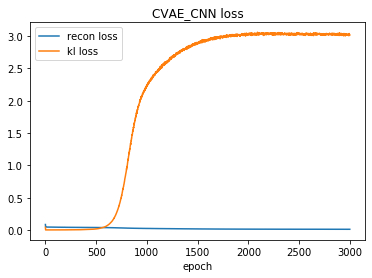

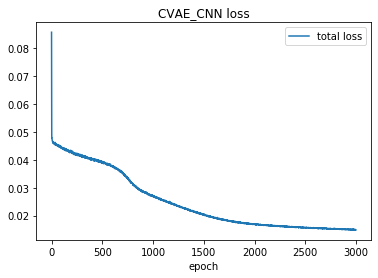

In [22]:
x = np.arange(0,3000)

plt.figure()
l2 = plt.plot(x, epoch_recon_loss, label='recon loss')
l3 = plt.plot(x, epoch_kl_loss, label='kl loss')
plt.title('CVAE_CNN loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.figure()
l1 = plt.plot(x, epoch_loss, label='total loss')
plt.title('CVAE_CNN loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Test for Lego Dataset, CVAE_CNN model

143
(300, 104)
0.36614318126863377 0.8830256247833131
0.33245177501863377 0.11439279442208772


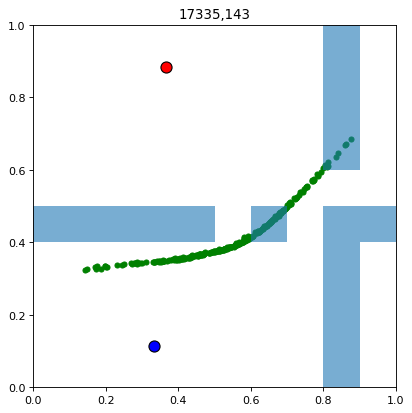

In [26]:
#net = CVAE()
#net.load_state_dict(torch.load(
#      "/home/zhizuo/lego/Model/lego2dCVAE_2019_12_27_16.pkl"))
data = np.array(process_it(G, directory))
num_viz = 300
# sample points of landmark
#vizIdx = randint(0, numTest - 1)
vizIdx = np.random.choice(range(4297))
#vizIdx = 88
print(vizIdx)
c_sample_seed = data[numTrain + vizIdx, 2:]
#c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
path = data[numTrain + vizIdx, 0:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))
c_sample_seed = torch.FloatTensor(c_sample_seed)
#print(y_viz)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    z = z.view(1, 2, 1,-1)
    tmp = c_sample_seed[0:4]
    tmp = tmp.view(1, 4, 1, -1)
    z = torch.cat((z, tmp), 1)
    z_deconv = net.deconv_de(z)
    c = c_sample_seed[4:104].view(1, 1, 10, 10)
    y = net.decoder(torch.cat((z_deconv, c),1))
    y = y.view(1, 128)
    predict = net.predict_mlp(y)
    y_viz[i,:] = predict
    
y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(path[0], path[1], color = 'green', s = 20)
plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

print(init[0], init[1])
print(goal[0], goal[1])
plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


# Train for DOF Landmark Dataset

In [ ]:
ratioTestTrain = 0.8
numEntries = landmark_data.shape[0]
numTrain = int(numEntries * ratioTestTrain)
X_train = landmark_data[0:numTrain,100:102]
c_train = landmark_data[0:numTrain,0:100]
X_test = landmark_data[numTrain:numEntries,100:102]
c_test = landmark_data[numTrain:numEntries,0:100]
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)

net = CVAE_MLP()
#resume = "/home/zhizuo/lego/Model/lego2dCVAE_2020_3_4_0.pkl"
#resume == None
#if resume == None:
#    net = CVAE_CNN()
#else:
#    net.load_state_dict(torch.load(resume))
if(torch.cuda.is_available()):
    net.cuda()
net.train()

optimizer = optim.Adam(net.parameters(), lr = opt.lr, betas=(opt.b1,opt.b2), 
                       eps = opt.eps, weight_decay = 0)

for epoch in range(opt.n_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0.0
    epoch_loss = 0.0
    for x, c in train_loader:
        i += 1
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / i
    print("Average loss of epoch {} Recon = {:.8f}, KL = {:.8f}, Loss = {:.6f}".
         format(epoch + 1, i, recon_loss, kl_loss, loss))
    if(epoch + 1)%1000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(),
                  '/home/zhizuo/lego/Model/lego2d_CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE_CNN")
net.eval()

Starting the 1 epoch
Average loss of epoch 1 Recon = 682.00000000, KL = 0.38783458, Loss = 99.956390
Starting the 2 epoch
Average loss of epoch 2 Recon = 682.00000000, KL = 0.24451275, Loss = 97.403694
Starting the 3 epoch
Average loss of epoch 3 Recon = 682.00000000, KL = 0.21331200, Loss = 120.112122
Starting the 4 epoch
Average loss of epoch 4 Recon = 682.00000000, KL = 0.20904623, Loss = 122.604774
Starting the 5 epoch
Average loss of epoch 5 Recon = 682.00000000, KL = 0.18860741, Loss = 128.703003
Starting the 6 epoch
Average loss of epoch 6 Recon = 682.00000000, KL = 0.16114922, Loss = 120.740425
Starting the 7 epoch
Average loss of epoch 7 Recon = 682.00000000, KL = 0.15579909, Loss = 129.371063
Starting the 8 epoch
Average loss of epoch 8 Recon = 682.00000000, KL = 0.15855339, Loss = 127.962807
Starting the 9 epoch
Average loss of epoch 9 Recon = 682.00000000, KL = 0.13281532, Loss = 114.815910
Starting the 10 epoch
Average loss of epoch 10 Recon = 682.00000000, KL = 0.11393926

In [4]:
a = np.array([[4, 3],
              [3, 5]])
b = np.linalg.inv(a)
print(b)

[[ 0.45454545 -0.27272727]
 [-0.27272727  0.36363636]]
